# Examine trans effect of TP53 Hotspot mutation in Colon Cancer

### Specifically examine Protein Abundance and Phosphorylation of PLK1

#### Library Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats

import cptac
import cptac.utils as ut

import seaborn as sns
import matplotlib.pyplot as plt

#Use Ovarian cancer object
co = cptac.Colon()

/anaconda3/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Use parse hotspot utility to analyze TP53 hotspot mutation in Ovarian cancer

#### Get somatic mutation data from cptac

In [2]:
somatic_mutations = co.get_somatic_mutation()

#### Use parse hotspot utility

In [3]:
vis, binary, detailed, dictionary = ut.parse_hotspot('../../HotspotClusterFiles/DanHeader_MyData.maf.3D_Proximity.pairwise.recurrence.l0.r10.clusters', somatic_mutations)

In [4]:
vis

,hotspot_id,patients_within
0,A2M,6.0
1,ABCB6,6.0
2,ACAA1,11.0
3,ACACB,2.0
4,ACADSB,5.0
5,ACAP1,4.0
6,ACBD3,3.0
7,ACLY,6.0
8,ACP5,20.0
9,ACVRL1,19.0


As we can see, TP53 has 5 hotspots in Ovarian cancer

#### Select only TP53 Hotspots

In [5]:
#There are 5 TP53 hotspots
TP53_Hotspots = detailed[['TP53','TP53_1']]
TP53_Hotspots.head()

,TP53,TP53_1
sample_id,,
S001,No,No
S002,No,No
S003,No,No
S004,No,No
S005,No,No


#### Make binary column for samples that have a TP53 Hotspot Mutation

In [6]:
TP53_Hotspots['Hotspot_Mutation'] = ''
for ind, row in TP53_Hotspots.iterrows():
    for col in TP53_Hotspots.columns:
        if row[col] == 'Yes_HS':
            TP53_Hotspots.loc[ind,'Hotspot_Mutation'] = 'TP53_Hotspot_Mutation'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

#### Grab only the binary yes/no hotspot mutation

In [7]:
binary_hotspots = TP53_Hotspots['Hotspot_Mutation']

#### Get Proteomic data, append Binary hotspot mutation column

In [8]:
#Use join omics to mutations
proteomics_df = co.join_omics_to_mutations(omics_genes=['PLK1'], omics_df_name='proteomics', mutations_genes='TP53')

#Remove multiindex from df
#proteomics_df = co.reduce_multiindex(proteomics_df, levels_to_drop='Database_ID')

#Remove Non-Tumor Samples
proteomics_df = proteomics_df.loc[proteomics_df['Sample_Status'] == 'Tumor']

#Remove columns that are not needed
proteomics_df = proteomics_df.drop(['TP53_Location','Sample_Status'],axis=1)
proteomics_df['TP53_Hotspot_Mutation'] = binary_hotspots

#Show df
proteomics_df.head()

Name,PLK1_proteomics,TP53_Mutation,TP53_Mutation_Status,TP53_Hotspot_Mutation
Patient_ID,,,,
S001,NaN,"[nonsynonymous SNV, nonsynonymous SNV, nonsyno...",Multiple_mutation,
S002,NaN,"[frameshift insertion, frameshift insertion, f...",Multiple_mutation,
S003,NaN,[Wildtype_Tumor],Wildtype_Tumor,
S004,NaN,[Wildtype_Tumor],Wildtype_Tumor,
S005,NaN,"[nonsynonymous SNV, nonsynonymous SNV, nonsyno...",Multiple_mutation,


#### Classify every sample according to TP53 Mutation Status. Use: Wildtype, Hotspot_Missense, Other_Missense, Truncation

In [9]:
for ind, row in proteomics_df.iterrows():
    if row['TP53_Hotspot_Mutation'] == 'TP53_Hotspot_Mutation':
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Hotspot_Missense'
        
    if 'frameshift insertion' in row['TP53_Mutation'] or 'frameshift deletion' in row['TP53_Mutation'] or 'stopgain' in row['TP53_Mutation']:
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Truncation'
        
    if row['TP53_Mutation_Status'] == 'Wildtype_Tumor':
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Wildtype'
    
    if row['TP53_Hotspot_Mutation'] != 'TP53_Hotspot_Mutation':
        if 'nonsynonymous SNV' in row['TP53_Mutation'] or 'nonframeshift deletion' in row['TP53_Mutation'] or 'nonframeshift insertion' in row['TP53_Mutation']:
            proteomics_df.loc[ind, 'TP53_Categorical'] = 'Other_Missense'
        
proteomics_df = proteomics_df.drop(['TP53_Mutation', 'TP53_Mutation_Status', 'TP53_Hotspot_Mutation'], axis = 1)
proteomics_df

Name,PLK1_proteomics,TP53_Categorical
Patient_ID,,
S001,NaN,Other_Missense
S002,NaN,Truncation
S003,NaN,Wildtype
S004,NaN,Wildtype
S005,NaN,Other_Missense
S006,0.6120,Other_Missense
S007,NaN,Wildtype
S008,NaN,Other_Missense
S009,NaN,Wildtype


### Perform t-tests on each protein, comparing Hotspot-Wildtype, Hotspot-Truncation, and Hotspot-Other Missense Mutations

In [10]:
for col in proteomics_df:
    if col != 'TP53_Categorical':
        hotspot_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Hotspot_Missense'][col].dropna()
        truncation_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Truncation'][col].dropna()
        other_missense_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Other_Missense'][col].dropna()
        wt_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Wildtype'][col]
        
        #Hotspot-WT comparison
        stat, pval = scipy.stats.ttest_ind(hotspot_df, wt_df)
        print("Omics: ", col, "\nComparison: Hotspot vs. Wildtype \nP-Value: ", str(pval))
        
        #Hotspot-Truncation comparison
        stat, pval = scipy.stats.ttest_ind(hotspot_df, truncation_df)
        print("\nOmics: ", col, "\nComparison: Hotspot vs. Truncation \nP-Value: ", str(pval))
        
        #Hotspot-Other Missense comparison
        stat, pval = scipy.stats.ttest_ind(hotspot_df, other_missense_df)
        print("\nOmics: ", col, "\nComparison: Hotspot vs. Other Missense \nP-Value: ", str(pval))
        print("\n\n")
        

Omics:  PLK1_proteomics 
Comparison: Hotspot vs. Wildtype 
P-Value:  nan

Omics:  PLK1_proteomics 
Comparison: Hotspot vs. Truncation 
P-Value:  nan

Omics:  PLK1_proteomics 
Comparison: Hotspot vs. Other Missense 
P-Value:  nan





#### Reformat dataframe for plot

In [11]:
plotdf = pd.melt(proteomics_df, id_vars='TP53_Categorical', var_name='Protein', value_name='Abundance')
plotdf = plotdf.replace({'PLK1_proteomics':'PLK1'})
plotdf = plotdf.replace({'Hotspot_Missense':'Hotspot Missense','Other_Missense':'Other Missense'})

### Make plot illustrating proteomic abundance

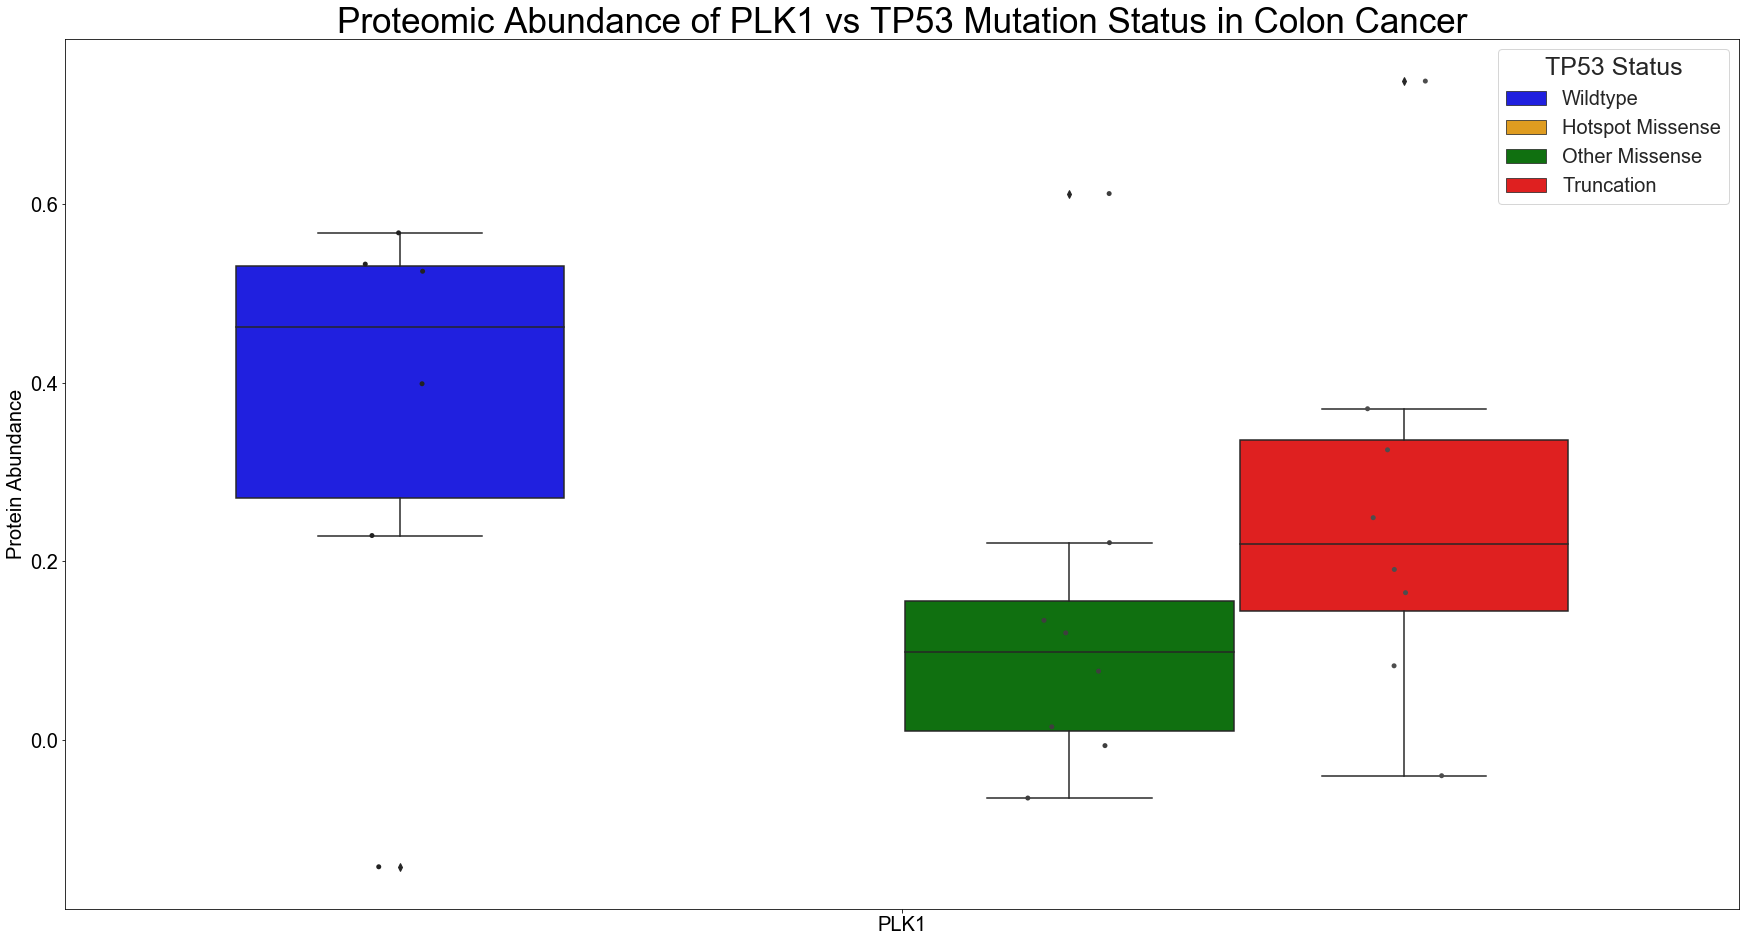

In [12]:
#Set dimensions and Colors
a4_dims = (30, 16)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Wildtype": "blue", "Hotspot Missense": "orange", "Other Missense":"green","Truncation":"red"}

#Make Boxplot
plot = sns.boxplot(data=plotdf, y = 'Abundance', x='Protein', hue='TP53_Categorical', palette=my_pal, hue_order=['Wildtype','Hotspot Missense','Other Missense','Truncation'])

#Overlay Striplot
plot = sns.stripplot(data=plotdf, y = 'Abundance', x='Protein', hue='TP53_Categorical', color='.3', jitter=True, dodge=True, hue_order=['Wildtype','Hotspot Missense','Other Missense','Truncation'])

#Change Style and label sizes
plot.tick_params(labelsize=20)
plot.set_xlabel('')
plot.set_ylabel('Protein Abundance', fontsize='20')
plot.set_title('Proteomic Abundance of PLK1 vs TP53 Mutation Status in Colon Cancer', fontsize = '35')
sns.set_style("white")

#Adjust the Legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:4],['Wildtype','Hotspot Missense','Other Missense','Truncation'], title='TP53 Status', fontsize='20', frameon=True)
plot.get_legend().get_title().set_fontsize('25')


### Conclusions: